Dataset Shape: (200, 5)

Data Types:
Exercise_Time_Min        float64
Healthy_Meals_Per_Day      int64
Sleep_Hours_Per_Night    float64
Stress_Level               int64
BMI                      float64
dtype: object

Descriptive Statistics:
       Exercise_Time_Min  Healthy_Meals_Per_Day  Sleep_Hours_Per_Night  \
count         200.000000             200.000000             200.000000   
mean           29.592290               2.875000               6.933582   
std             9.310039               1.815449               1.422471   
min             3.802549               0.000000               1.778787   
25%            22.948723               2.000000               5.967243   
50%            29.958081               3.000000               6.972331   
75%            35.008525               4.000000               7.886509   
max            57.201692               9.000000              10.708419   

       Stress_Level         BMI  
count    200.000000  200.000000  
mean       4.995000   25

  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


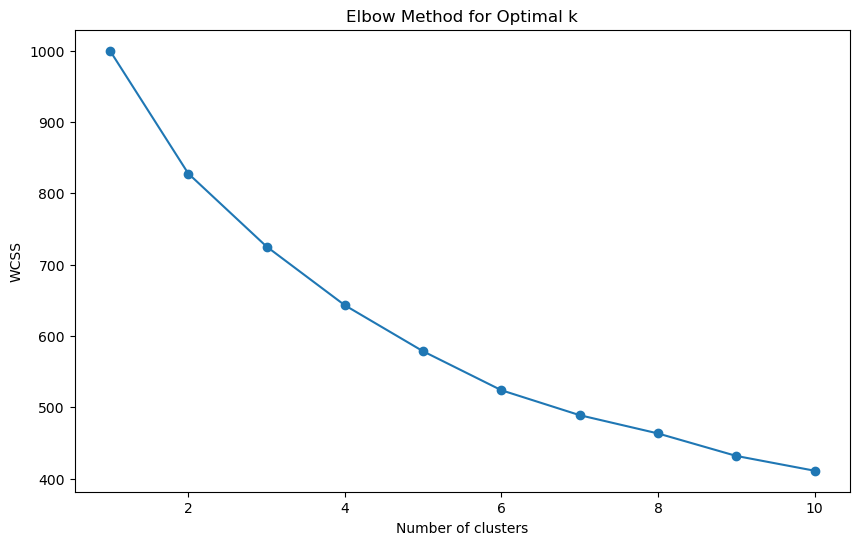

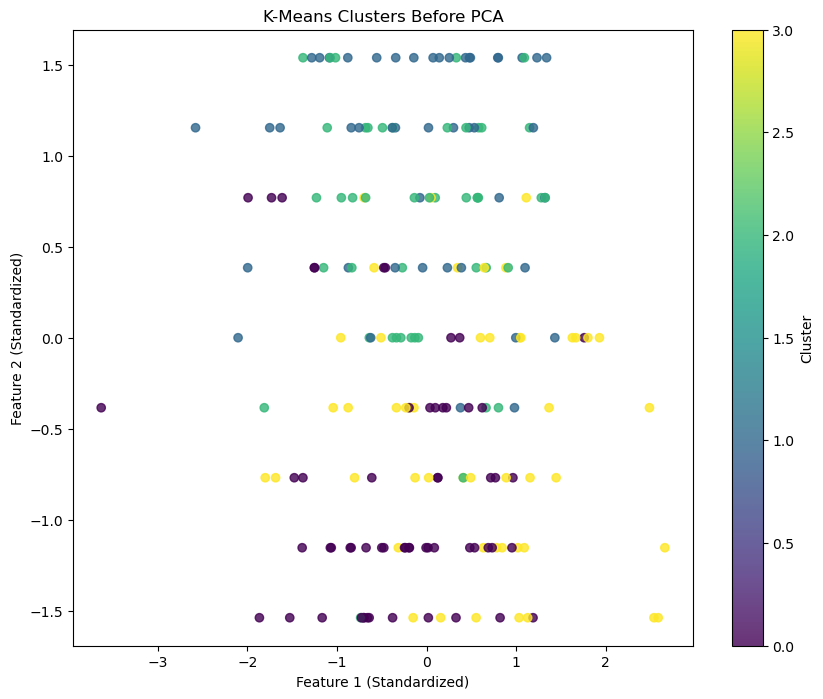

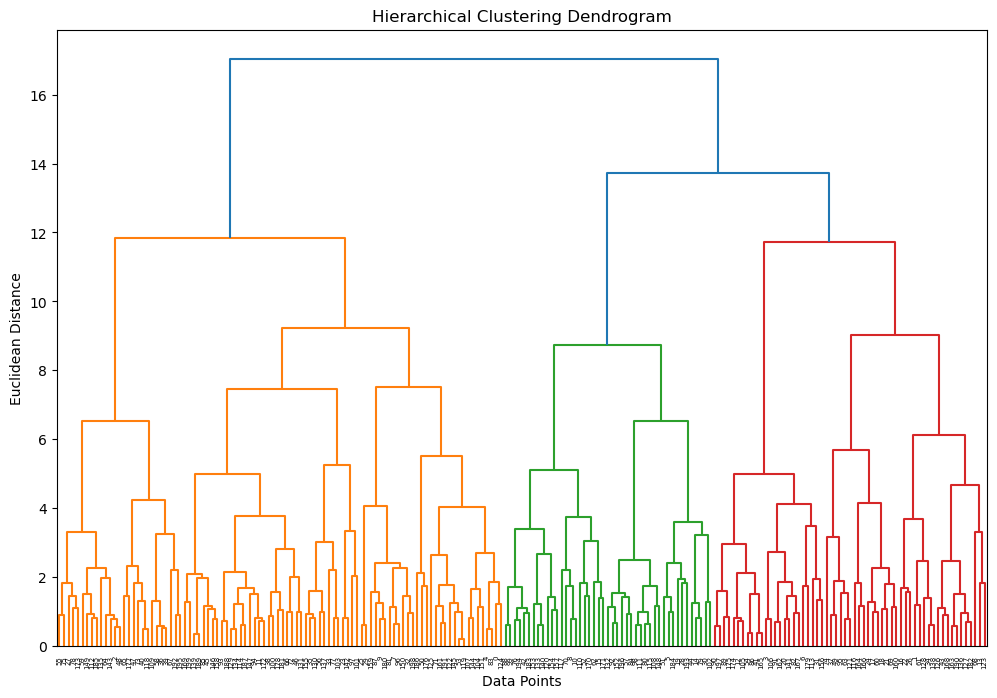


Number of components selected: 4
Explained variance ratio: [0.23691549 0.22082517 0.19828377 0.18362786]
Cumulative explained variance: 0.84


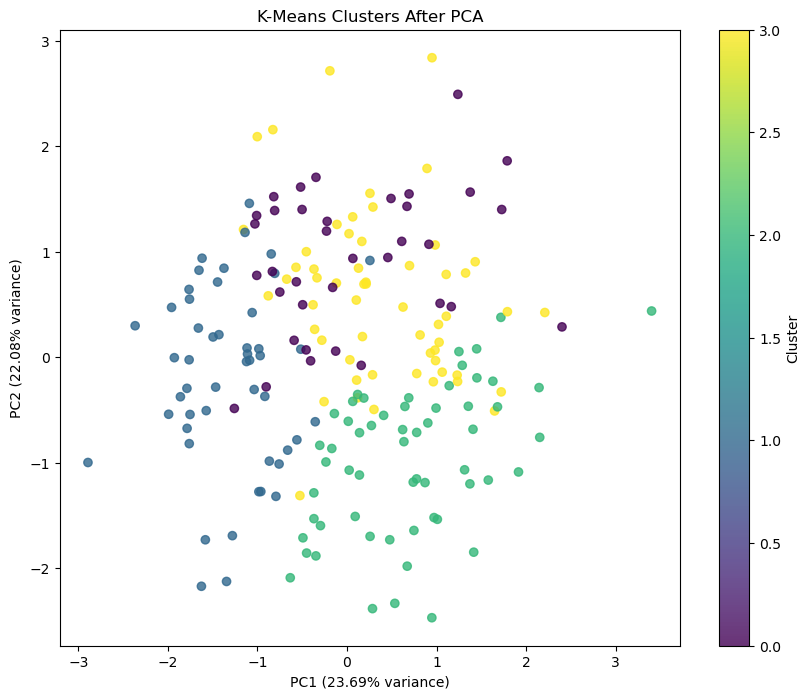

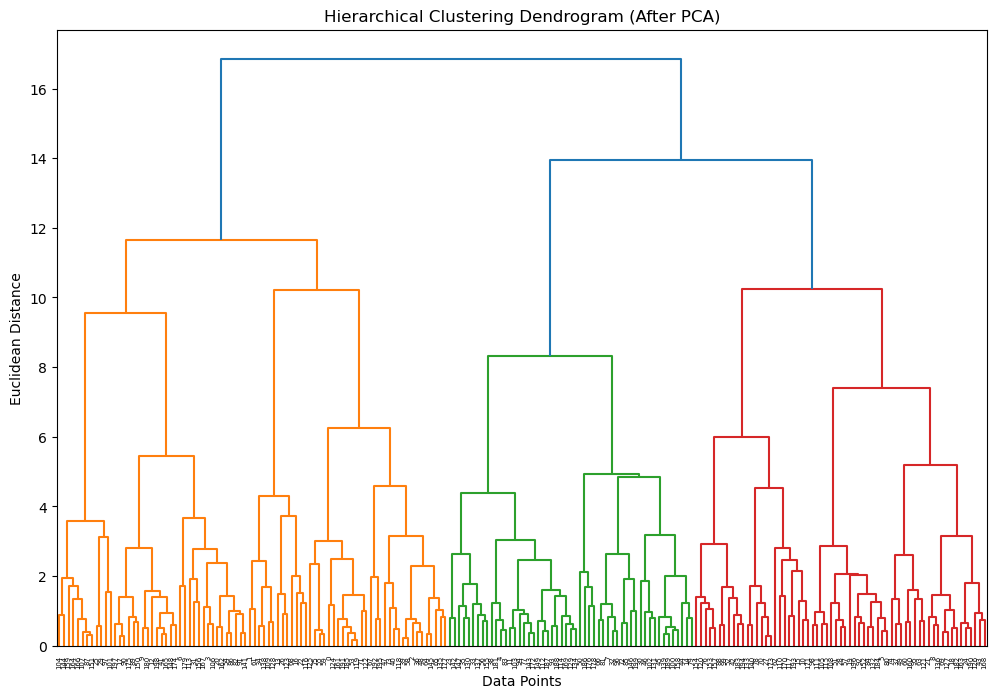


Clustering Performance Comparison (Before vs After PCA):
                            Metric  Before PCA   After PCA  Difference
0       Silhouette Score (K-Means)    0.168586    0.203051    0.034466
1                   WCSS (K-Means)  643.142085  488.980794 -154.161291
2  Silhouette Score (Hierarchical)    0.114392    0.162919    0.048527


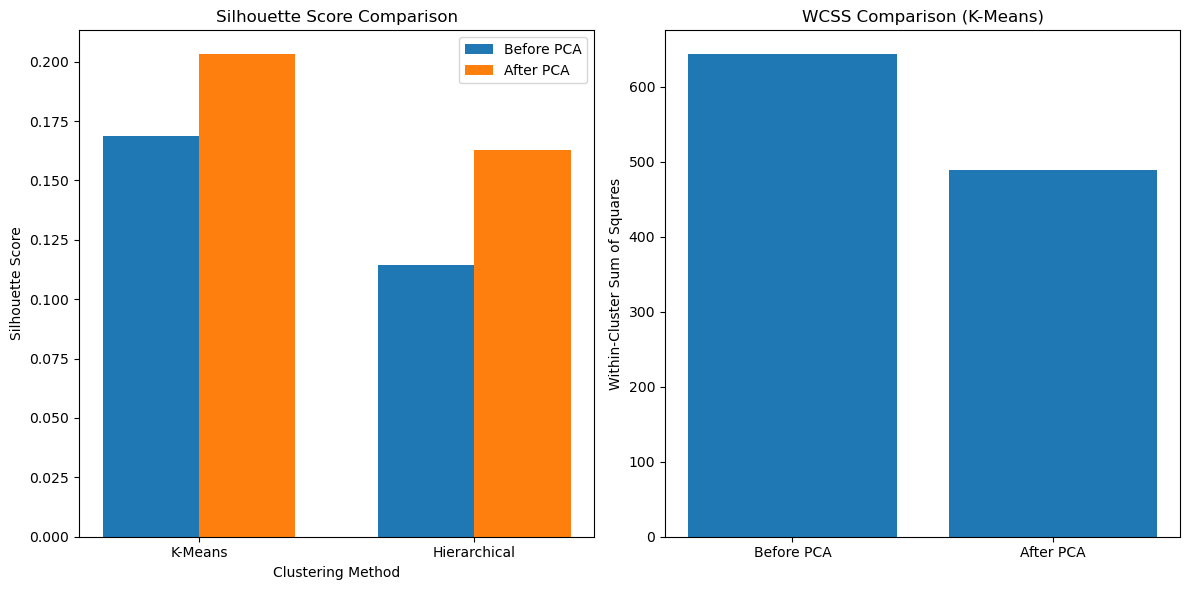

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

#Load and explore the data
df = pd.read_csv('health_data.csv')

#Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nDescriptive Statistics:")
print(df.describe())

#Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


#Prepare data for clustering
features = ['Sleep_Hours_Per_Night', 'Stress_Level', 'Healthy_Meals_Per_Day', 'BMI', 'Exercise_Time_Min']
X = df[features].copy()

#Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Determine optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#Apply K-Means clustering 
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['kmeans_cluster'] = kmeans_labels

#Calculate K-Means metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_wcss = kmeans.inertia_

#Scatter plot of clusters before PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.8)
plt.title('K-Means Clusters Before PCA')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.colorbar(label='Cluster')
plt.show()

#Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)
df['hierarchical_cluster'] = hierarchical_labels

#Calculate Hierarchical Clustering metrics
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)

#Visualize hierarchical clustering with dendrogram
plt.figure(figsize=(12, 8))
dendrogram_plot = dendrogram(linkage(X_scaled, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

#Implement PCA with cumulative variance of at least 70%
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

#Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_70 = np.argmax(cumulative_variance >= 0.70) + 1 

#Run PCA with the selected number of components
pca = PCA(n_components=n_components_70)
X_pca = pca.fit_transform(X_scaled)

#Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"\nNumber of components selected: {n_components_70}")
print(f"Explained variance ratio: {explained_variance}")
print(f"Cumulative explained variance: {sum(explained_variance):.2f}")

#Apply clustering on PCA reduced data
kmeans_pca = KMeans(n_clusters=k, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(X_pca)
kmeans_pca_silhouette = silhouette_score(X_pca, kmeans_pca_labels)
kmeans_pca_wcss = kmeans_pca.inertia_

#Hierarchical on PCA data
hierarchical_pca = AgglomerativeClustering(n_clusters=k)
hierarchical_pca_labels = hierarchical_pca.fit_predict(X_pca)
hierarchical_pca_silhouette = silhouette_score(X_pca, hierarchical_pca_labels)

#Scatter plot of clusters after PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca_labels, cmap='viridis', alpha=0.8)
plt.title('K-Means Clusters After PCA')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.colorbar(label='Cluster')
plt.show()

#Visualize hierarchical clustering with dendrogram after PCA
plt.figure(figsize=(12, 8))
dendrogram_plot_pca = dendrogram(linkage(X_pca, method='ward'))
plt.title('Hierarchical Clustering Dendrogram (After PCA)')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

#Compare clustering results before and after PCA
comparison_data = {
    'Metric': ['Silhouette Score (K-Means)', 'WCSS (K-Means)', 'Silhouette Score (Hierarchical)'],
    'Before PCA': [kmeans_silhouette, kmeans_wcss, hierarchical_silhouette],
    'After PCA': [kmeans_pca_silhouette, kmeans_pca_wcss, hierarchical_pca_silhouette],
    'Difference': [
        kmeans_pca_silhouette - kmeans_silhouette,
        kmeans_pca_wcss - kmeans_wcss,
        hierarchical_pca_silhouette - hierarchical_silhouette
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nClustering Performance Comparison (Before vs After PCA):")
print(comparison_df)

#Visualize the comparison
plt.figure(figsize=(12, 6))

#Silhouette Score Comparison
plt.subplot(1, 2, 1)
x = np.arange(2)
width = 0.35
plt.bar(x - width/2, [kmeans_silhouette, hierarchical_silhouette], width, label='Before PCA')
plt.bar(x + width/2, [kmeans_pca_silhouette, hierarchical_pca_silhouette], width, label='After PCA')
plt.xlabel('Clustering Method')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison')
plt.xticks(x, ['K-Means', 'Hierarchical'])
plt.legend()

#WCSS Comparison (K-Means only)
plt.subplot(1, 2, 2)
plt.bar(['Before PCA', 'After PCA'], [kmeans_wcss, kmeans_pca_wcss])
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('WCSS Comparison (K-Means)')

plt.tight_layout()
plt.show()